In [12]:
LEARNING_RATE = 0.01
TRAINING_ITERATIONS = 2000
DISPLAY_STEP = 100
METHOD_NAME = 'softmax'


DROPOUT = 0.5
BATCH_SIZE = 50

RUN_DEEPNET = False
VALIDATION_SIZE = 4200

if RUN_DEEPNET:
    LEARNING_RATE = 1e-4
    TRAINING_ITERATIONS = 20000
    DISPLAY_STEP = 1000
    METHOD_NAME = 'deepnet'

In [1]:
import pandas as pd

# read training data from CSV file 
data = pd.read_csv("/home/duygu/Downloads/train.csv")
print("data({0[0]},{0[1]})".format(data.shape))
print (data.head())

data(42000,785)
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0         0         0   
3       0    ...            0         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0   

In [2]:
labels_flat = data[[0]].values.ravel()
print("labels_flat({0})".format(len(labels_flat)))

labels_flat(42000)


In [3]:
import numpy as np

''' 
Convert class labels from scalars to one-hot vectors
0 => [1 0 0 0 0 0 0 0 0 0]
1 => [0 1 0 0 0 0 0 0 0 0]
...
9 => [0 0 0 0 0 0 0 0 0 1]
'''
def dense_to_one_hot(labels_dense, num_classes=10):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

labels = dense_to_one_hot(labels_flat)
labels = labels.astype(np.uint8)
print("labels({0[0]},{0[1]})".format(labels.shape))

labels(42000,10)


In [4]:
images = data.iloc[:,1:].values
images = images.astype(np.float)

# convert from [0, 255] => [0.0, 1.0]
images = np.multiply(images, 1.0 / 255.0)
print("images({0[0]},{0[1]})".format(images.shape))

images(42000,784)


[0 1 0 0 0 0 0 0 0 0]
1


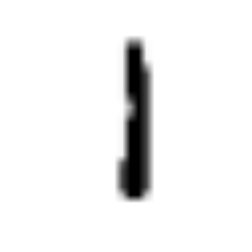

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# display image
def display(img):
    one_image = np.multiply(img.reshape(28,28),255).astype(np.uint8)
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)

# display third image    
display(images[2])
print (labels[2])
print (labels_flat[2])

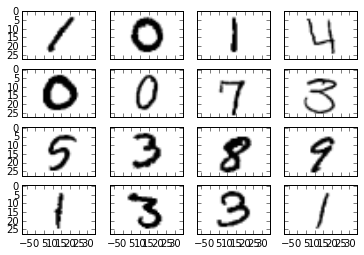

In [9]:
f, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12), (ax13, ax14, ax15, ax16)) = plt.subplots(4, 4, sharex='col', sharey='row')
for t,x in zip([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16], range(16)):
    one_image = np.multiply(images[x].reshape(28,28),255).astype(np.uint8)
    t.imshow(one_image, cmap=cm.binary)

In [13]:
validation_images = images[:VALIDATION_SIZE]
validation_labels = labels[:VALIDATION_SIZE]

train_images = images[VALIDATION_SIZE:]
train_labels = labels[VALIDATION_SIZE:]

print("train_images({0[0]},{0[1]})".format(train_images.shape))
print("validation_images({0[0]},{0[1]})".format(validation_images.shape))

train_images(37800,784)
validation_images(4200,784)


In [16]:
import tensorflow as tf

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


# convolution and pooling
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [17]:
# setup TensorFlow graph

# input & output
x = tf.placeholder("float", shape=[None, 784])
y_ = tf.placeholder("float", shape=[None, 10])


# first convolutional layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x, [-1,28,28,1])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)


# second convolutional layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)


# densely connected layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)


# dropout
keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)


# readout layer for deep net
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])


# readout layer for regression
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))


if RUN_DEEPNET:
    y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
else:
    y = tf.nn.softmax(tf.matmul(x, W) + b)
    

# cost function
cross_entropy = -tf.reduce_sum(y_*tf.log(y))


# optimisation function
if RUN_DEEPNET:
    train_step = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(cross_entropy)
else:
    train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)

    
# evaluation
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

# prediction function
predict = tf.argmax(y,1)

In [18]:
epochs_completed = 0
index_in_epoch = 0
num_examples = train_images.shape[0]

# serve data by batches
def next_batch(batch_size):
    
    global train_images
    global train_labels
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_images[start:end], train_labels[start:end]

In [19]:
init = tf.initialize_all_variables()
with tf.Session() as sess:
    sess.run(init)
    
    for i in range(TRAINING_ITERATIONS):
        
        #get new batch
        batch_xs, batch_ys = next_batch(BATCH_SIZE)        
        
        # check progress
        if i%DISPLAY_STEP == 0 and i:
            train_accuracy = accuracy.eval(feed_dict={x:batch_xs, y_: batch_ys, keep_prob: 1.0})
            print("training accuracy:\t %.4f for step %d"%(train_accuracy, i))
        
        # train on batch
        sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: DROPOUT})
    
    
    # check final accuracy on validation set  
    if(VALIDATION_SIZE):
        print('validation accuracy:\t %.4f'%sess.run(accuracy, feed_dict={x: validation_images, y_: validation_labels, keep_prob: 1.0}))
    
 
    # predict test set
    predicted_lables = sess.run(predict, feed_dict={x: test_images, keep_prob: 1.0})
    
    # save results
    np.savetxt('submission_'+METHOD_NAME+'.csv', np.c_[range(1,len(test_images)+1),predicted_lables], delimiter=',', header = 'ImageId,Label', comments = '', fmt='%d')
        
    print("predicted_lables({0})".format(len(predicted_lables)))

training accuracy:	 0.9200 for step 100
training accuracy:	 0.8400 for step 200
training accuracy:	 0.9400 for step 300
training accuracy:	 0.8400 for step 400
training accuracy:	 0.8600 for step 500
training accuracy:	 0.8600 for step 600
training accuracy:	 0.9000 for step 700
training accuracy:	 0.9600 for step 800
training accuracy:	 0.9200 for step 900
training accuracy:	 0.9600 for step 1000
training accuracy:	 0.8600 for step 1100
training accuracy:	 0.9200 for step 1200
training accuracy:	 0.9200 for step 1300
training accuracy:	 0.9800 for step 1400
training accuracy:	 0.9000 for step 1500
training accuracy:	 0.9600 for step 1600
training accuracy:	 0.9400 for step 1700
training accuracy:	 0.9800 for step 1800
training accuracy:	 0.9200 for step 1900
validation accuracy:	 0.9086
predicted_lables(28000)


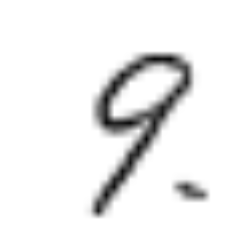

In [20]:
display(test_images[2])

In [21]:
print (predicted_lables[2])

9


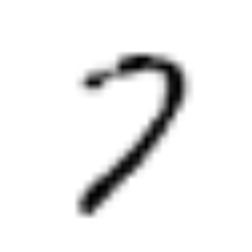

In [22]:
display(test_images[11])

In [23]:
print (predicted_lables[11])

7


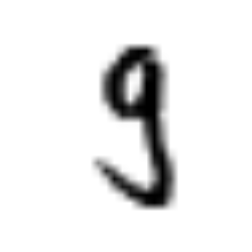

In [25]:
display(test_images[101])

In [26]:
print (predicted_lables[101])

3


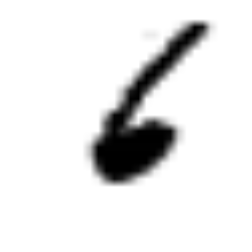

In [27]:
display(test_images[124])

In [28]:
print (predicted_lables[124])

6


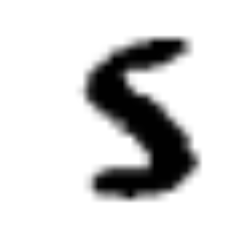

In [31]:
display(test_images[621])

In [32]:
print (predicted_lables[621])

5
